# Business Challange

## Planning IoT

### Input

    1. Goal

        1.1 Anticipate the first destination the new user will book
    
    2. Data
        2.1 age_gender
        2.2 countries
        2.3 sessions
        2.4 test_users
        2.5 train_users

### Output

    1. Report Analysis about user behavior
    2. Machine Learning Model to predict users booking

### Tasks

    1. Define the best model with prediction
    2. Store the informaiton with prediction in a table
    3. Provide an API to access predictions

# Dev Env

## Imports

In [1]:
#============================Data Manipulation==========================
import numpy  as np
import pandas as pd
import pickle
from datetime import timedelta
from random   import randint

#============================Data Visualization==========================
import seaborn           as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from IPython.display     import Image
from pandas_profiling    import ProfileReport
from tabulate            import tabulate

#============================Statistical Test============================
from scipy.stats import chi2_contingency
from pycorrcat.pycorrcat import plot_corr, corr_matrix

#============================Data Preparation============================
from sklearn.preprocessing            import LabelEncoder
from sklearn.preprocessing            import MinMaxScaler
from sklearn.preprocessing            import RobustScaler
from sklearn.preprocessing            import OneHotEncoder
from category_encoders.target_encoder import TargetEncoder
from category_encoders.count          import CountEncoder
from feature_engine.encoding          import CountFrequencyEncoder

#============================Balancing Dataset===========================
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling  import RandomOverSampler
from imblearn.combine        import SMOTETomek
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling  import SMOTE

#============================Machine Learning============================
import random
from keras                   import models
from keras                   import layers
from sklearn.dummy           import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from scikitplot.metrics      import plot_confusion_matrix
from sklearn.metrics         import balanced_accuracy_score
from sklearn.metrics         import accuracy_score
from sklearn.metrics         import cohen_kappa_score
from sklearn.ensemble        import RandomForestClassifier
from sklearn.ensemble        import ExtraTreesClassifier
from boruta                  import BorutaPy

2022-01-15 17:18:05.376023: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-15 17:18:05.376040: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Functions

### EDA

In [184]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).as_matrix()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

In [185]:
def graph_info_num(fig=None, title=str, xlabel=str, ylabel=str, x_rotation=0):
    '''
    --> Settings and information for a graph with numerical xaxis
    
    :param None fig: The figure to personalize
    :param str title: The graph title
    :param str ylabel: The Y label description
    :param str xlabel: The X label description
    :param int x_rotation: The X ticker roation
    '''
    plt.figure(figsize=(12, 8))
    fig.xaxis.set_major_locator(ticker.IndexLocator(base=12, offset=0))
    fig.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}'))
    plt.title(title, loc='left', size=22)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=14)
    plt.xticks(rotation=x_rotation)
    plt.show()

In [186]:
def graph_info_cat(title=str, xlabel='', ylabel='', x_rotation=0):
    '''
    --> Settings and information for a graph with categorical xaxis
    
    :param None fig: The figure to personalize
    :param str title: The graph title
    :param str ylabel: The Y label description
    :param str xlabel: The X label description
    :param int x_rotation: The X ticker roation
    '''
    plt.title(title, loc='left', size=22)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=14)
    plt.xticks(rotation=x_rotation)
    plt.show()

### Model Performance

In [35]:
def model_evaluation(y_true=None, y_pred=None):
    '''
    --> Show classification metrics
    
    :param y_true: The true values of target
    :param y_pred: The predictions made by model
    '''
    print(f'Accuracy: {round(accuracy_score(y_true, y_pred), 1) * 100}%')
    print(f'Balanced Accuracy Score: {round(balanced_accuracy_score(y_true, y_pred), 1) * 100}%')
    print(f'Kappa Score: {cohen_kappa_score(y_true, y_pred)}')
    
    # Confusion Matrix
    plot_confusion_matrix(y_true, y_pred, figsize=(12, 8))
    plt.show()

In [33]:
def model_evaluation_cv(y_true=None, y_pred=None):
    '''
    --> Show classification metrics
    
    :param y_true: The true values of target
    :param y_pred: The predictions made by model
    
    return accuracy_score, balanced_accuracy_score, kappa_score
    '''
    ac = round(accuracy_score(y_true, y_pred), 2) 
    bc = round(balanced_accuracy_score(y_true, y_pred), 2)
    ks = round(cohen_kappa_score(y_true, y_pred), 4)
    return ac, bc, ks

## Settings

In [2]:
# Random seed
seed = random.seed(24)

# Visualization
plt.rcParams['figure.figsize'] = [18,14]
sns.set_style(style='darkgrid')
%matplotlib inline

## Data Raw

In [12]:
## age_gender
#age_gender = pd.read_csv('../data/age_gender_bkts.csv')
#
## countries
#countries = pd.read_csv('../data/countries.csv')
#
## sessions
#sessions = pd.read_csv('../data/sessions.csv')

# train users
train_users = pd.read_csv('../data/raw/train_users_2.csv')

# Data Description

    - Data Types
    - Dealing with NaN
    - Descriptive Statistics

## Data Input

In [163]:
df1 = pd.read_csv('../data/raw/train_users_2.csv')
df1.head(3)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US


## Data Types

In [112]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [19]:
# Change
# date_account_created        datetime
# date_first_booking          datetime
# age                         int
# signup_flow                 int64

## Check NaN

In [79]:
# Proportion of NaN by column
round(df1.isna().sum() / len(df1) * 100, 1)

id                          0.0
date_account_created        0.0
timestamp_first_active      0.0
date_first_booking         58.3
gender                      0.0
age                        41.2
signup_method               0.0
signup_flow                 0.0
language                    0.0
affiliate_channel           0.0
affiliate_provider          0.0
first_affiliate_tracked     2.8
signup_app                  0.0
first_device_type           0.0
first_browser               0.0
country_destination         0.0
dtype: float64

## Fill NaN

### date_first_booking

In [164]:
'''
Challenge
 - 58.0 of user don't made a booking, the attribution of the booking is that user decide in 3 to 5 days like 
traveling to any place
'''

# Fill the NaN of first booking with random number between 3 and 5 days after date account created
df1['date_first_booking'].fillna(pd.to_datetime(df1['date_account_created']) + timedelta(days=randint(3, 5)), inplace=True)

### age

In [165]:
# Fill the age with Median
df1['age'].fillna(round(df1['age'].median()), inplace=True)

### first_affiliate_tracked

In [166]:
# Drop NaN of affiliate tracked
df1.dropna(subset=['first_affiliate_tracked'], inplace=True)

### sessions

In [41]:
#df_sessions.dropna(inplace=True)

## Change Types

In [167]:
# Change
# date_account_created        datetime
df1['date_account_created'] = pd.to_datetime(df1['date_account_created'])

# date_first_booking          datetime
df1['date_first_booking'] = pd.to_datetime(df1['date_first_booking'])

# timestamp_first_active
df1['timestamp_first_active'] = pd.to_datetime(df1['timestamp_first_active'], format='%Y%m%d%H%M%S')

# age                         int
df1['age'] = df1['age'].astype('int64')
                                           
# signup_flow                 int64
df1['signup_flow'] = df1['signup_flow'].astype('int64') 

## Check Balanced Data

In [155]:
# Data are imbalanced with two majors classes
round(df1['country_destination'].value_counts(normalize=True) * 100, 1)

NDF      58.0
US       29.4
other     4.8
FR        2.4
IT        1.3
GB        1.1
ES        1.1
CA        0.7
DE        0.5
NL        0.4
AU        0.3
PT        0.1
Name: country_destination, dtype: float64

## Data Output

In [168]:
# Data with cicle transformation
df1.to_csv('../data/processed/df1.csv', index=False)

## Descriptive Statistics

### Data Input

In [ ]:
df1 = pd.read_csv('../data/processed/df1.csv')

### Numerical Attributes

In [23]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])

In [24]:
desc = num_attributes.describe().T

# range
_range = pd.Series(desc['max'] - desc['min'], name='range')

# skew
skew = pd.Series(num_attributes.skew(), name='skew')

# kurtosis
kurtosis = pd.Series(num_attributes.kurtosis(), name='kurtosis')

# Concat data
desc = pd.concat([desc, _range, skew, kurtosis], axis=1)

In [25]:
desc[['count', 'min', 'max', 'range', 'mean', '50%', 'std', '25%', '75%', 'skew', 'kurtosis']]

,count,min,max,range,mean,50%,std,25%,75%,skew,kurtosis
age,213451.0,1.0,2014.0,2013.0,43.209444,34.0,119.592797,32.0,36.0,16.263619,264.656719
signup_flow,213451.0,0.0,25.0,25.0,3.267387,0.0,7.637707,0.0,0.0,2.234366,3.324444


    - Age have stranges minimum and maximum data

### Categorical Attributes

In [26]:
cat_attributes = df1.select_dtypes(include='object')

In [27]:
cat_attributes.drop(columns='id').describe().T

,count,unique,top,freq
date_account_created,213451,1634,2014-05-13,674
timestamp_first_active,213451,213451,2009-03-19 04:32:55,1
date_first_booking,88908,1976,2014-05-22,248
gender,213451,4,-unknown-,95688
signup_method,213451,3,basic,152897
language,213451,25,en,206314
affiliate_channel,213451,8,direct,137727
affiliate_provider,213451,18,direct,137426
first_affiliate_tracked,207386,7,untracked,109232
signup_app,213451,4,Web,182717


    - 2014 represent the top year
    - Users use basic signup method on Web (Google Chome) plataforms, with Mac Desktop and undefined destination

# Feature Engineering

    - Mind Map Hypothesis
    - Hypothesis statments
    - New Feature Derivation

## Data Input

In [169]:
df4 = pd.read_csv('../data/processed/df1.csv')
df4.head(3)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,2010-07-01,-unknown-,34,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,2011-05-28,MALE,38,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US


## Mind Map Hypothesis

<font size=5>Feature already available</font>

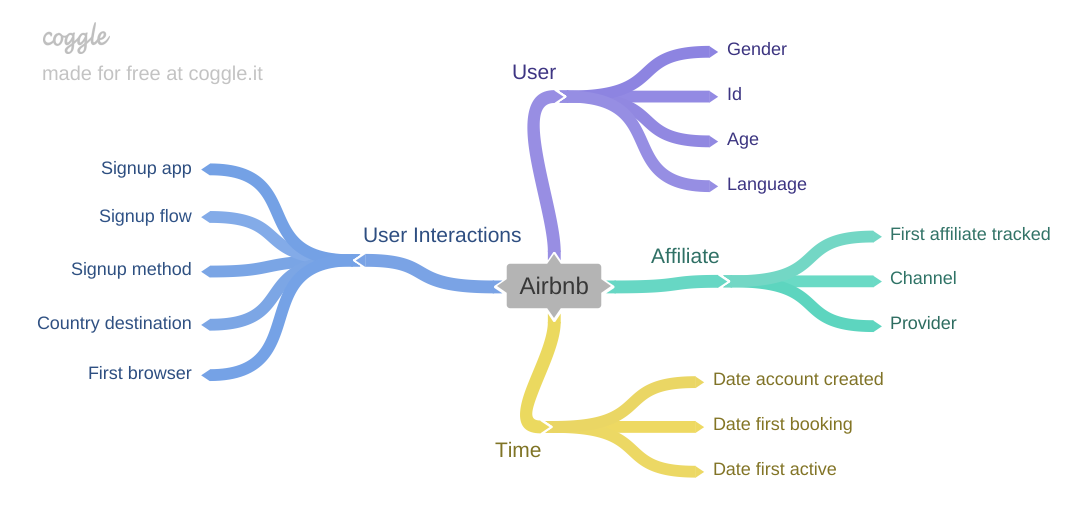

In [23]:
Image('../img/airbnb.png')

<font size=5>New Features</font>

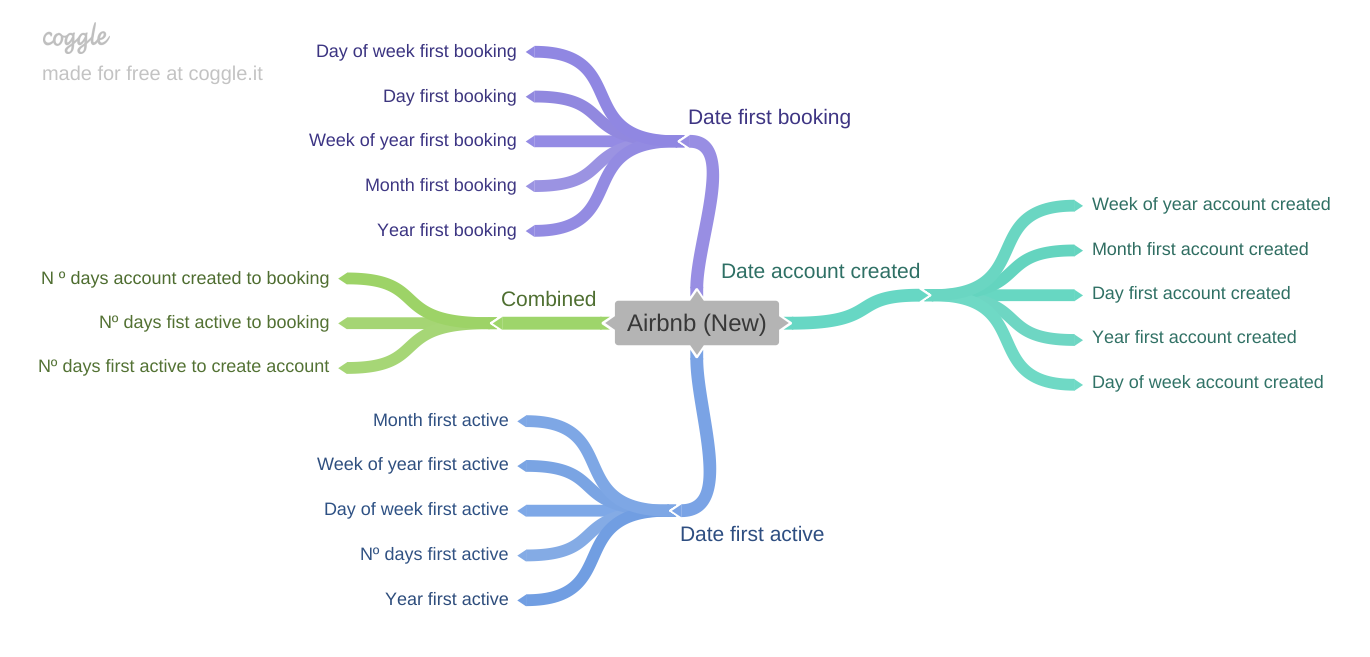

In [25]:
Image('../img/airbnb_new.png')

## User Hypothesis

    H1. Users under 30 age represet 80% of users  

## Time Hypothesis

    H1. 90% of the days of the first booking is on the weekend
    H2. The average to have a first booking is 30 days
    H3. The number of booking have increase 30% over the years

## User Interactions Hypothesis

    H1. Mobile is the user preference on 70% of time to signup app
    H2. 80% of users with defined destination country sign up via the web

## Affiliate Hypothesis

    H1. Google represent 80% of affiliate channel 

## Hypothesis List

    H1. 90% of the days of the first booking is on the weekend
    
    H2. The average to have a first booking is 30 days
    
    H3. The number of booking have increase 30% over the years
    
    H4. Mobile is the user preference on 70% of time to signup app
    
    H5. 80% of users with defined destination country sign up via the web
    
    H6. Google represent 80% of affiliate channel 

## Features Derived

In [170]:
df4['timestamp_first_active'] = pd.to_datetime(pd.to_datetime(df4['timestamp_first_active']).dt.strftime('%Y-%m-%d'))
df4['date_first_booking'] = pd.to_datetime(df4['date_first_booking'])
df4['date_account_created'] = pd.to_datetime(df4['date_account_created'])

In [176]:
((df4['date_first_booking'] - df4['date_account_created']).apply(lambda x: x.days if x.days >= 0 else 0) < 0).sum()

0

In [177]:
# ================== First Active ==================
# days from first active up to first booking
df4['days_first_active_to_booking'] = (df4['date_first_booking'] - df4['timestamp_first_active']).apply(lambda x: x.days)

# days from first active upt to account created
df4['days_first_active_to_account_created'] = (df4['date_account_created'] - df4['timestamp_first_active']).apply(lambda x: x.days)

# days from account createad up to first booking
# If date_first booking < data_account_created x = 0
df4['days_account_created_first_booking'] = (df4['date_first_booking'] - df4['date_account_created']).apply(lambda x: x.days if x.days >= 0 else 0)

# year first active
df4['year_first_active'] = df4['timestamp_first_active'].dt.year

# month first active
df4['month_first_active'] = df4['timestamp_first_active'].dt.month

# day first active
df4['day_first_active'] = df4['timestamp_first_active'].dt.day

# day of week first active
df4['day_of_week_first_active'] = df4['timestamp_first_active'].dt.dayofweek

# week of year first active
df4['week_of_year_first_active'] = df4['timestamp_first_active'].dt.isocalendar().week

# ================== First Booking ==================
# year first booking
df4['year_first_booking'] = df4['date_first_booking'].dt.year

# month first booking
df4['month_first_booking'] = df4['date_first_booking'].dt.month

# day first booking
df4['day_first_booking'] = df4['date_first_booking'].dt.day

# day of week first booking
df4['day_of_week_first_booking'] = df4['date_first_booking'].dt.dayofweek

# week of year first booking
df4['week_of_year_first_booking'] = df4['date_first_booking'].dt.isocalendar().week

# ================== Account Created =================
# year first account_created
df4['year_account_created'] = df4['date_account_created'].dt.year

# month  account_created
df4['month_account_created'] = df4['date_account_created'].dt.month

# day  account_created
df4['day_account_created'] = df4['date_account_created'].dt.day

# day of week  account_created
df4['day_of_week_account_created'] = df4['date_account_created'].dt.dayofweek

# week of year  account_created
df4['week_of_year_account_created'] = df4['date_account_created'].dt.isocalendar().week

## Data Output

In [179]:
df4.to_csv('../data/processed/feature_engineering.csv', index=False)

# EDA

Gols
    
    1. Business Understanding
    
    2. Hypothesis Validation
    
    3. Features Importance

## Data Input

In [180]:
df5 = pd.read_csv('../data/processed/feature_engineering.csv')

## Univariate Analysis

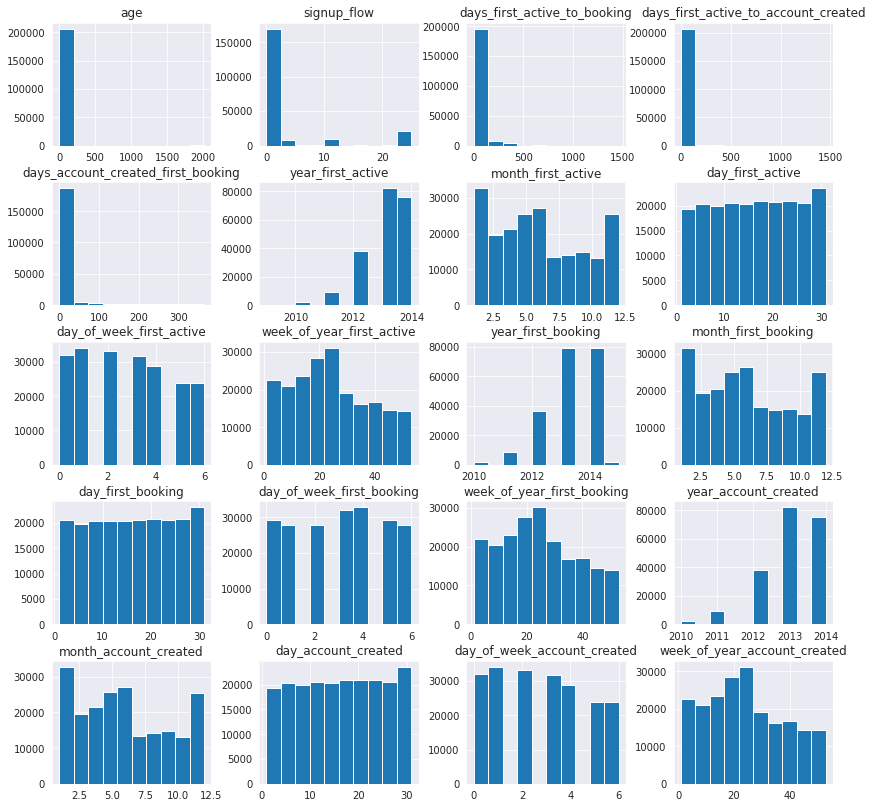

In [181]:
df5.hist(figsize = (14, 14))
plt.show()

Notes:    
    
    age: Have outliers
    
    signup_flow: High bias
    
    day_fist_booking: Concentrated on the end of the month and in weekend
    
    week_of_year_first_booking: User tend to have a booking at the middle of the year
    
    month_first_booking: User have a first booking at the beggining and ending of the year

In [10]:
#prof = ProfileReport(df5.select_dtypes(include='object'))
#prof.to_file('univariate_analysis_categorical.html')

<font size=5><a href="univariate_analysis_categorical.html">Profiling Report</a></font>

## Bivariate Analysis

### Hypothesis Test

#### H1. 90% of the days of the first booking is on the weekend

**Result:** False

**Metric:** Count

**Note:** The day of week first booking with country destination different of NDF are distribuited in all days of week 

<a href="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.dt.dayofweek.html">The day of the week with Monday=0, Sunday=6.</a>

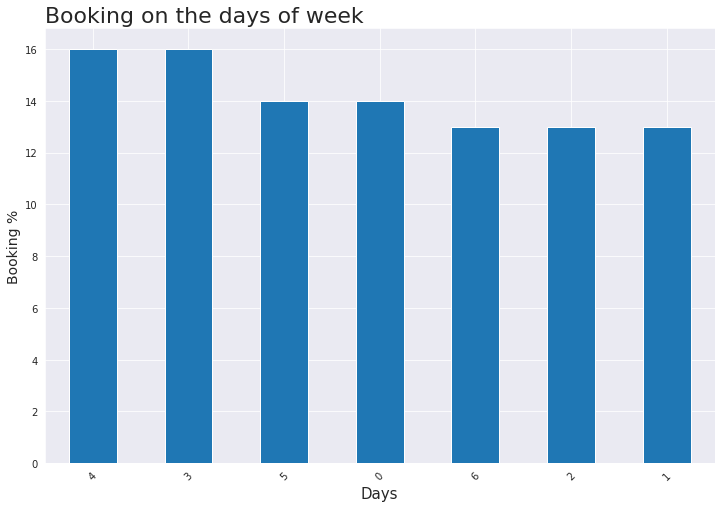

In [188]:
plt.figure(figsize=(12, 8))
round(df5['day_of_week_first_booking'].value_counts(normalize=True) * 100).plot(kind='bar')
graph_info_cat('Booking on the days of week', 'Days', 'Booking %', 45)

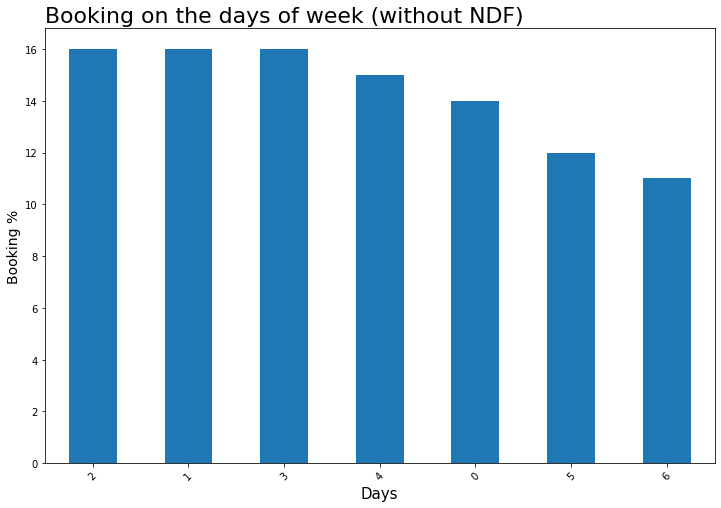

In [26]:
plt.figure(figsize=(12, 8))
round(df5[df5['country_destination'] != 'NDF']['day_of_week_first_booking'].value_counts(normalize=True) * 100).plot(kind='bar')
graph_info_cat('Booking on the days of week (without NDF)', 'Days', 'Booking %', 45)

#### H2. The average to have a first booking is 30 days

   **Result:** False
    
   **Metric:** Median
   
   **Note:** The median is until 5 days

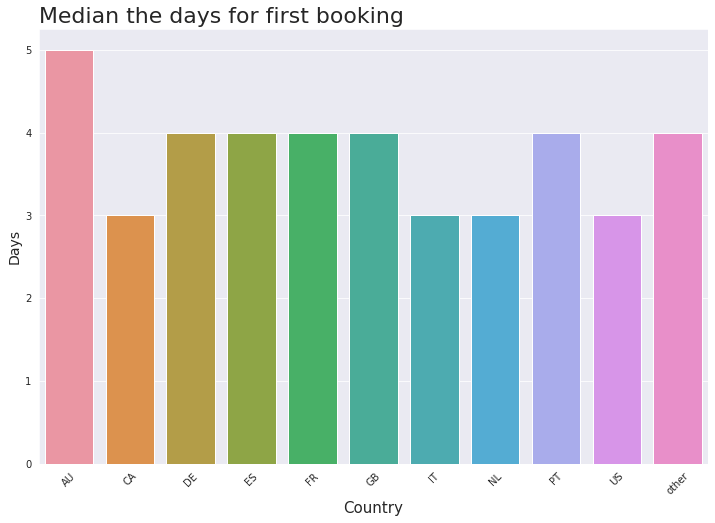

In [189]:
plt.figure(figsize=(12, 8))
aux = df5[df5['country_destination'] != 'NDF'][['country_destination', 'days_account_created_first_booking']].\
                                          groupby('country_destination').median().reset_index()
sns.barplot(x='country_destination', y='days_account_created_first_booking', data=aux)
graph_info_cat('Median the days for first booking', 'Country', 'Days', 45)

#### H3. The number of booking have increase 30% over the years 

**Result:** False

**Metric:** Proportion

**Note:** The increase was over 30% from 2013 to 2015, but decreased to 4% in 2014.

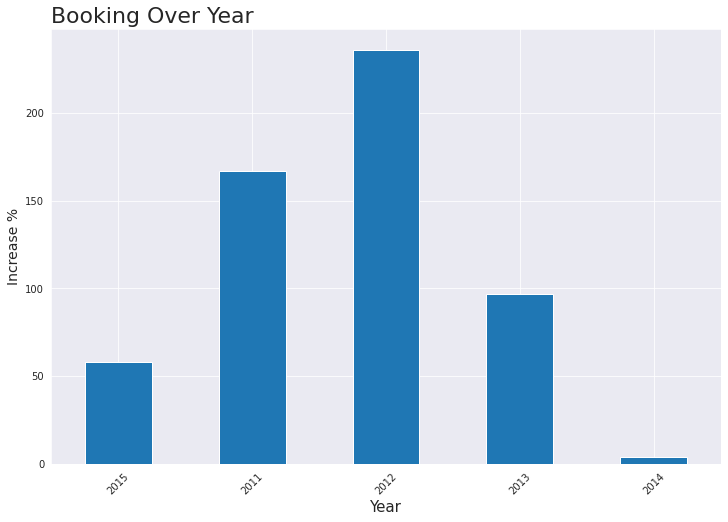

In [202]:
plt.figure(figsize=(12, 8))
round(df5[df5['country_destination'] != 'NDF']['year_first_booking'].value_counts(normalize=False, ascending=True).\
      pct_change() * 100).dropna().plot(kind='bar')
graph_info_cat('Booking Over Year', 'Year', 'Increase %', 45)

#### H4. Mobile is the user preference on 70% of time to signup app

**Result:** False

**Metric:** Amount

**Note:** Web have been the preference

In [41]:
df5['signup_app'].value_counts(normalize=True) * 100

Web        85.991340
iOS         8.617264
Moweb       2.793342
Android     2.598054
Name: signup_app, dtype: float64

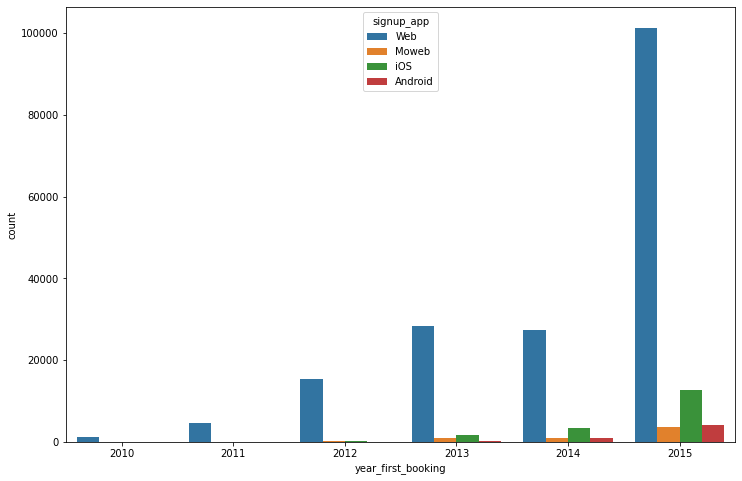

In [49]:
plt.figure(figsize=(12, 8))
sns.countplot(x='year_first_booking', data=df5, hue='signup_app')
plt.show()

#### H5. 80% of users with defined destination country sign up via the web

**Result:** True

**Metric:** Proportion

**Note:** Web represents 90% of users that have country destination in all period (mobile have increase over the years)

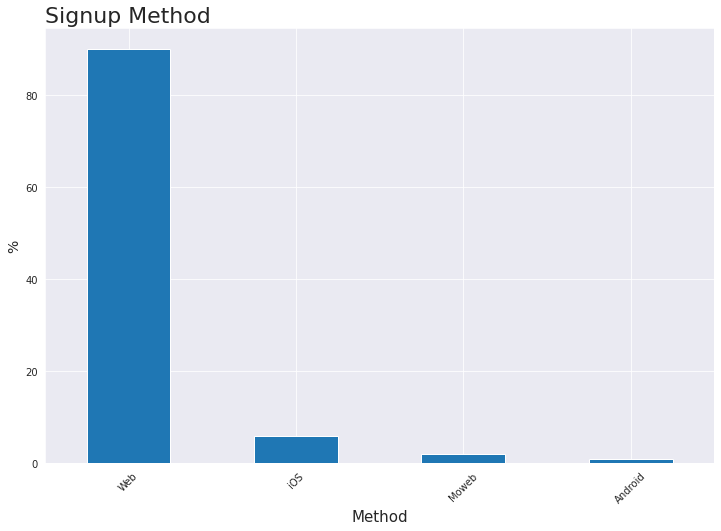

In [196]:
round(df5[df5['country_destination'] != 'NDF']['signup_app'].value_counts(normalize=True) * 100).plot(kind='bar',
                                                                                                 figsize=(12,8))
graph_info_cat('Signup Method', 'Method', '%', 45)

In [12]:
round(pd.crosstab(df5[df5['country_destination'] != 'NDF']['signup_app'], 
            df5[df5['country_destination'] != 'NDF']['year_first_booking'], normalize='columns') * 100)

year_first_booking,2010,2011,2012,2013,2014,2015
signup_app,,,,,,
Android,0.0,0.0,0.0,1.0,3.0,4.0
Moweb,0.0,0.0,1.0,3.0,3.0,3.0
Web,100.0,100.0,97.0,91.0,84.0,74.0
iOS,0.0,0.0,2.0,5.0,10.0,19.0


#### H6. Google represent 80% of affiliate provider

**Result:** False

**Metric:** Market Share

**Note:** Diret is the biggest affiliate provider

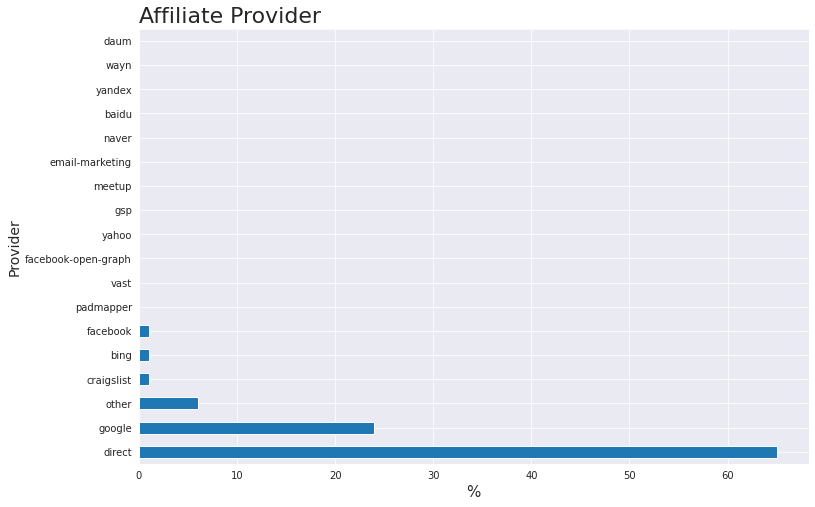

In [201]:
round(df5['affiliate_provider'].value_counts(normalize=True) * 100).plot(kind='barh', figsize=(12,8))
graph_info_cat('Affiliate Provider', '%', 'Provider')

In [25]:
round(pd.crosstab(df5['affiliate_provider'], df5['year_first_booking'], normalize='columns') * 100)

year_first_booking,2010,2011,2012,2013,2014,2015
affiliate_provider,,,,,,
baidu,0.0,0.0,0.0,0.0,0.0,0.0
bing,0.0,1.0,1.0,1.0,1.0,1.0
craigslist,22.0,11.0,4.0,0.0,0.0,1.0
daum,0.0,0.0,0.0,0.0,0.0,0.0
direct,50.0,56.0,67.0,71.0,65.0,63.0
email-marketing,0.0,0.0,0.0,0.0,0.0,0.0
facebook,1.0,0.0,1.0,1.0,1.0,1.0
facebook-open-graph,0.0,0.0,0.0,0.0,0.0,0.0
google,24.0,26.0,18.0,21.0,28.0,25.0


#### Hypothesis Result

In [63]:
tab = [['Hypothesis', 'Result', 'Relevance'], 
      ['H1. 90% of the days of the first booking is on the weekend', 'False', 'High'],
      ['H2. The average to have a first booking is 30 days', 'False', 'Low'],
      ['H3. The number of booking have increase 30% over the years', 'False', 'High'],
      ['H4. Mobile is the user preference on 70% of time to signup app', 'False', 'Medium'],
      ['H5. 80% of users with defined destination country sign up via the web', 'True', 'Low'],
      ['H6. Google represent 80% of affiliate provider', 'False', 'Medium']]
print(tabulate(tab, tablefmt='fancy_grid'))

╒═══════════════════════════════════════════════════════════════════════╤════════╤═══════════╕
│ Hypothesis                                                            │ Result │ Relevance │
├───────────────────────────────────────────────────────────────────────┼────────┼───────────┤
│ H1. 90% of the days of the first booking is on the weekend            │ False  │ High      │
├───────────────────────────────────────────────────────────────────────┼────────┼───────────┤
│ H2. The average to have a first booking is 30 days                    │ False  │ Low       │
├───────────────────────────────────────────────────────────────────────┼────────┼───────────┤
│ H3. The number of booking have increase 30% over the years            │ False  │ High      │
├───────────────────────────────────────────────────────────────────────┼────────┼───────────┤
│ H4. Mobile is the user preference on 70% of time to signup app        │ False  │ Medium    │
├─────────────────────────────────────────────────

### Correlation Analysis 

#### Numerical Attributes

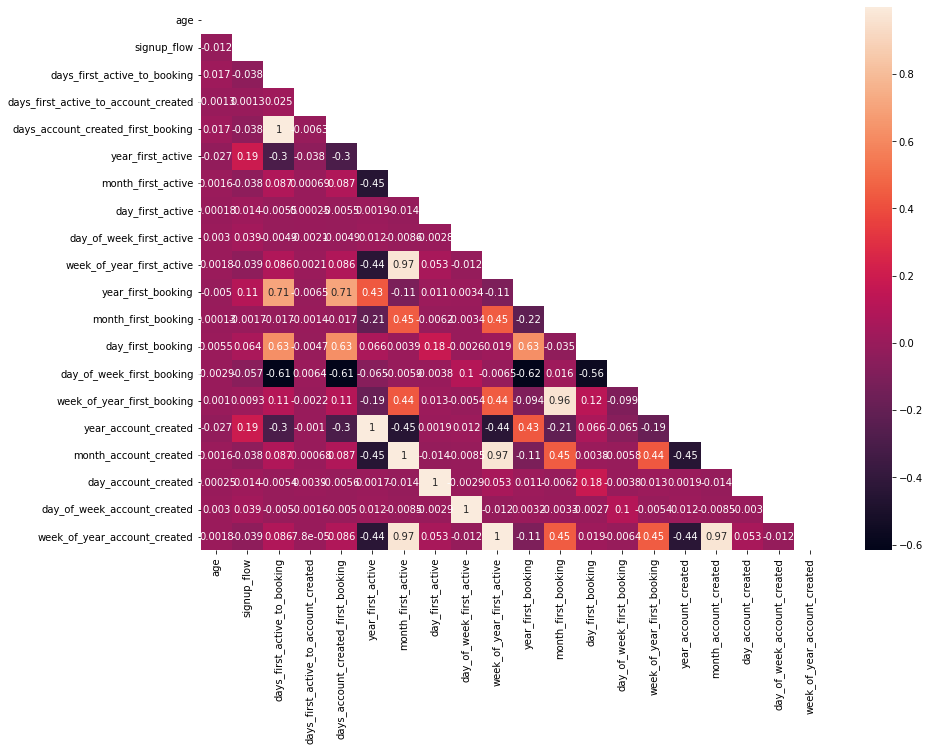

In [43]:
num_attributes = df5.select_dtypes(include=['int64', 'float64'])
corr_num = num_attributes.corr()
mask = np.zeros_like(corr_num)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(14, 10))
sns.heatmap(corr_num, mask=mask, annot=True)
plt.show()

<font size=4.5>Attributes with strong positive and negative correlations</font>

    Positive correlation > 0.7
    
    Negative correlation < -0.7

In [44]:
corr_upper = corr_num.where(np.triu(np.ones(corr_num.shape), k=1).astype('bool'))

In [45]:
[column for column in corr_upper.columns if (any(corr_upper[column] > 0.7)) | (any(corr_upper[column] < -0.7))]

['days_account_created_first_booking',
 'week_of_year_first_active',
 'year_first_booking',
 'week_of_year_first_booking',
 'year_account_created',
 'month_account_created',
 'day_account_created',
 'day_of_week_account_created',
 'week_of_year_account_created']

### Categorical Attributes

In [6]:
categorical_attributes = df5.select_dtypes(include='object').iloc[:, 4:]

In [46]:
corr_cat = corr_matrix(categorical_attributes, categorical_attributes.columns)

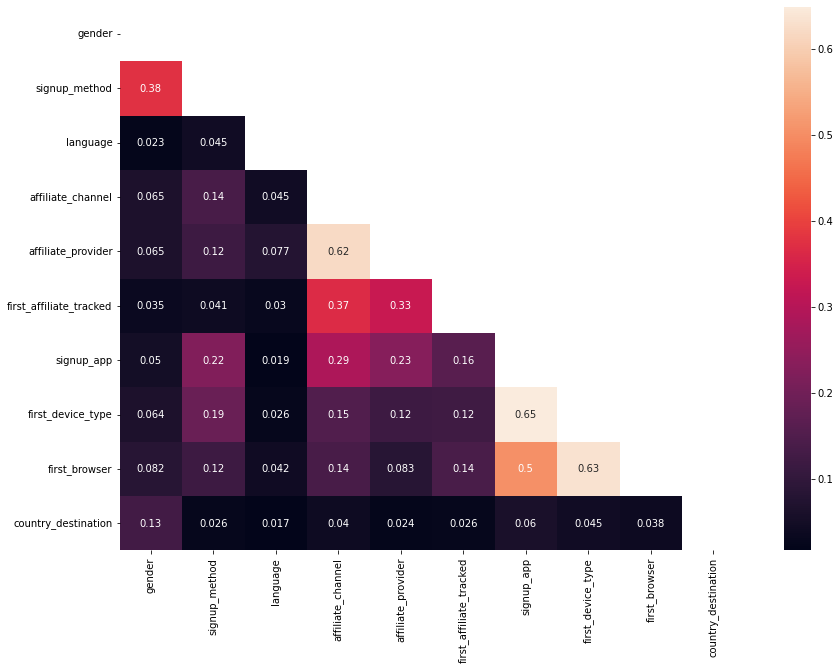

In [47]:
mask = np.zeros_like(corr_cat)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(14, 10))
sns.heatmap(corr_cat, mask=mask, annot=True)
plt.show()

In [48]:
corr_upper = corr_cat.where(np.triu(np.ones(corr_cat.shape), k=1).astype('bool'))

<font size=5>Columns with correlation upper of 0.5</font>

In [49]:
[column for column in corr_upper.columns if any(corr_upper[column] > 0.5)]

['affiliate_provider', 'first_device_type', 'first_browser']

### Variables With Correlation

In [208]:
header = ['NUMERICAL'] 
tab = [
      ['days_account_created_first_booking X days_first_active_to_booking'],
      ['week_of_year_first_active          X month_first_active'],
      ['year_first_booking                 X days_account_created_first_booking'],
      ['week_of_year_first_booking         X month_first_booking'],
      ['year_account_created               X year_first_active'],
      ['month_account_created              X month_first_active'],
      ['day_account_created                X day_first_active'],
      ['day_of_week_account_created        X day_of_week_first_active'],
      ['week_of_year_account_created       X month_account_created']]
print(tabulate(tab, header, tablefmt='github'))

| NUMERICAL                                                               |
|-------------------------------------------------------------------------|
| days_account_created_first_booking X days_first_active_to_booking       |
| week_of_year_first_active          X month_first_active                 |
| year_first_booking                 X days_account_created_first_booking |
| week_of_year_first_booking         X month_first_booking                |
| year_account_created               X year_first_active                  |
| month_account_created              X month_first_active                 |
| day_account_created                X day_first_active                   |
| day_of_week_account_created        X day_of_week_first_active           |
| week_of_year_account_created       X month_account_created              |


In [204]:
header = ['CATEGORICAL'] 
tab = [['affiliate_provider X affiliate_channel'], 
       ['first_device_type  X signup_app'], 
       ['first_browser      X first_device_type']]
print(tabulate(tab, header, tablefmt='github'))

| CATEGORICAL                            |
|----------------------------------------|
| affiliate_provider X affiliate_channel |
| first_device_type  X signup_app        |
| first_browser      X first_device_type |


<font size=4.5>The variable that are highly correlated will be drop to minimize the dimension of data, and because they explain the same phenomenon<font>

## Multivariate Analysis

# Data Filter

## Data Input

In [20]:
df6 = pd.read_csv('../data/processed/feature_engineering.csv')
df6.head(3)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,...,year_first_booking,month_first_booking,day_first_booking,day_of_week_first_booking,week_of_year_first_booking,year_account_created,month_account_created,day_account_created,day_of_week_account_created,week_of_year_account_created
0,gxn3p5htnn,2010-06-28,2009-03-19,2015-06-29,-unknown-,50,facebook,0,en,direct,...,2015,6,29,0,27,2010,6,28,0,26
1,820tgsjxq7,2011-05-25,2009-05-23,2015-06-29,MALE,38,facebook,0,en,seo,...,2015,6,29,0,27,2011,5,25,2,21
2,4ft3gnwmtx,2010-09-28,2009-06-09,2010-08-02,FEMALE,56,basic,3,en,direct,...,2010,8,2,0,31,2010,9,28,1,39


## Cols drop

In [21]:
# Drop columns related to date and with high correlation
# In the categorical features that are correlated the exclusion is the feature with more categories
cols_drop = ['date_account_created', 'timestamp_first_active', 'date_first_booking', 
             'days_account_created_first_booking', 'week_of_year_first_active', 'year_first_booking',
             'week_of_year_first_booking', 'year_account_created', 'month_account_created', 'day_account_created',
             'day_of_week_account_created', 'week_of_year_account_created', 'affiliate_provider', 
             'first_device_type', 'first_browser', 'language']
df6.drop(columns=cols_drop, inplace=True)

## Ignore improbable data

In [22]:
# Age upper than 15 and lower than 80
df6 = df6[(df6['age'] > 15) & (df6['age'] < 80)]

# secs elapsed upper than 0
#df6 = df6[df6['secs_elapsed'] > 0]

## Data Output

In [23]:
df6.to_csv('../data/processed/df_filter.csv', index=False)

# Data Preparation

## Data Input

In [12]:
df7 = pd.read_csv('../data/processed/df_filter.csv')

## Split Data

In [13]:
x = df7.drop(columns='country_destination').copy()
y = df7['country_destination'].copy()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed, stratify=y)

## Encoder 

In [14]:
#===================================LabelEncoder===================================
le = LabelEncoder()
# gender
x_train['gender'] = le.fit_transform(x_train['gender'])
x_test['gender']  = le.fit_transform(x_test['gender'])

# signup_method
x_train['signup_method'] = le.fit_transform(x_train['signup_method'])
x_test['signup_method']  = le.fit_transform(x_test['signup_method'])

# signup_app
x_train['signup_app'] = le.fit_transform(x_train['signup_app'])
x_test['signup_app']  = le.fit_transform(x_test['signup_app'])

#===================================CountFrequencyEncoder===========================
cfe = CountFrequencyEncoder(encoding_method='frequency')

country = {'NDF': 0, 'US': 1, 'GB': 2, 'NL': 3, 'other': 4, 'DE': 5, 'FR': 6, 'CA': 7, 'ES': 8, 'IT': 9, 'AU': 10,
          'PT': 11}
# affiliate_channel
x_train['affiliate_channel'] = cfe.fit_transform(x_train[['affiliate_channel']], y_train.map(country))
x_test['affiliate_channel'] = cfe.fit_transform(x_test[['affiliate_channel']], y_test.map(country))

# first_affiliate_tracked
x_train['first_affiliate_tracked'] = cfe.fit_transform(x_train[['first_affiliate_tracked']], y_train.map(country))
x_test['first_affiliate_tracked'] = cfe.fit_transform(x_test[['first_affiliate_tracked']], y_test.map(country))

## Rescaling

In [15]:
# ==================================MinMax===================================
mms = MinMaxScaler()
# age 
x_train['age'] = mms.fit_transform(x_train[['age']].values)
x_test['age'] = mms.fit_transform(x_test[['age']].values)

# year_first_active
x_train['year_first_active'] = mms.fit_transform(x_train[['year_first_active']].values)
x_test['year_first_active'] = mms.fit_transform(x_test[['year_first_active']].values)

# ==================================RobustScaler=============================
rs = RobustScaler()
# signup_flow 
x_train['signup_flow'] = rs.fit_transform(x_train[['signup_flow']].values)
x_test['signup_flow'] = rs.fit_transform(x_test[['signup_flow']].values)

# days_first_active_to_booking
x_train['days_first_active_to_booking'] = rs.fit_transform(x_train[['days_first_active_to_booking']].values)
x_test['days_first_active_to_booking'] = rs.fit_transform(x_test[['days_first_active_to_booking']].values)

# days_first_active_to_account_created
x_train['days_first_active_to_account_created'] = rs.fit_transform(x_train[['days_first_active_to_account_created']].values)
x_test['days_first_active_to_account_created'] = rs.fit_transform(x_test[['days_first_active_to_account_created']].values)

## Transformation

Note: Not recommended for tree models

Source: <a href="https://towardsdatascience.com/cyclical-features-encoding-its-about-time-ce23581845ca">Cyclical features encoding, it’s about time!</a>


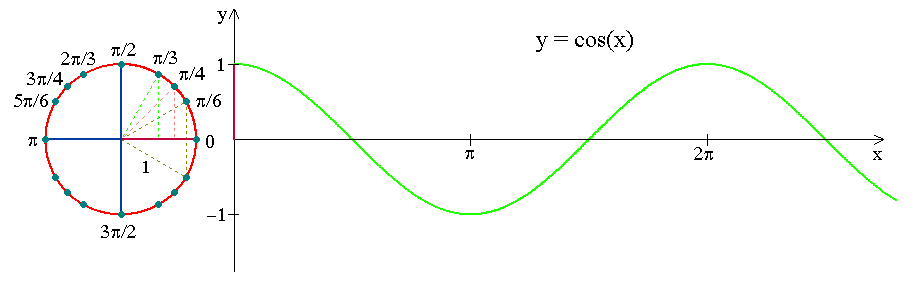

In [16]:
# ==================================Nature cine/ cosine===========================
# month_first_active 
x_train['month_first_active_sin'] = x_train['month_first_active'].apply(lambda x: np.sin(x * (2 * np.pi / 12)))
x_test['month_first_active_sin'] = x_test['month_first_active'].apply(lambda x: np.sin(x * (2 * np.pi / 12)))

x_train['month_first_active_cos'] = x_train['month_first_active'].apply(lambda x: np.cos(x * (2 * np.pi / 12)))
x_test['month_first_active_cos'] = x_test['month_first_active'].apply(lambda x: np.cos(x * (2 * np.pi / 12)))

# day_first_active
x_train['day_first_active_sin'] = x_train['day_first_active'].apply(lambda x: np.sin(x * (2 * np.pi / 30)))
x_test['day_first_active_sin'] = x_test['day_first_active'].apply(lambda x: np.sin(x * (2 * np.pi / 30)))

x_train['day_first_active_cos'] = x_train['day_first_active'].apply(lambda x: np.cos(x * (2 * np.pi / 30)))
x_test['day_first_active_cos'] = x_test['day_first_active'].apply(lambda x: np.cos(x * (2 * np.pi / 30)))

# day_of_week_first_active
x_train['day_of_week_first_active_sin'] = x_train['day_of_week_first_active'].apply(lambda x: np.sin(x * (2 * np.pi / 7)))
x_test['day_of_week_first_active_sin'] = x_test['day_of_week_first_active'].apply(lambda x: np.sin(x * (2 * np.pi / 7)))

x_train['day_of_week_first_active_cos'] = x_train['day_of_week_first_active'].apply(lambda x: np.cos(x * (2 * np.pi / 7)))
x_test['day_of_week_first_active_cos'] = x_test['day_of_week_first_active'].apply(lambda x: np.cos(x * (2 * np.pi / 7)))

# month_first_booking
x_train['month_first_booking_sin'] = x_train['month_first_booking'].apply(lambda x: np.sin(x * (2 * np.pi / 12)))
x_test['month_first_booking_sin'] = x_test['month_first_booking'].apply(lambda x: np.sin(x * (2 * np.pi / 12)))

x_train['month_first_booking_cos'] = x_train['month_first_booking'].apply(lambda x: np.cos(x * (2 * np.pi / 12)))
x_test['month_first_booking_cos'] = x_test['month_first_booking'].apply(lambda x: np.cos(x * (2 * np.pi / 12)))

# day_first_booking
x_train['day_first_booking_sin'] = x_train['day_first_booking'].apply(lambda x: np.sin(x * (2 * np.pi / 30)))
x_test['day_first_booking_sin'] = x_test['day_first_booking'].apply(lambda x: np.sin(x * (2 * np.pi / 30)))

x_train['day_first_booking_cos'] = x_train['day_first_booking'].apply(lambda x: np.cos(x * (2 * np.pi / 30)))
x_test['day_first_booking_cos'] = x_test['day_first_booking'].apply(lambda x: np.cos(x * (2 * np.pi / 30)))

# day_of_week_first_booking
x_train['day_of_week_first_booking_sin'] = x_train['day_of_week_first_booking'].apply(lambda x: np.sin(x * (2 * np.pi / 7)))
x_test['day_of_week_first_booking_sin'] = x_test['day_of_week_first_booking'].apply(lambda x: np.sin(x * (2 * np.pi / 7)))

x_train['day_of_week_first_booking_cos'] = x_train['day_of_week_first_booking'].apply(lambda x: np.cos(x * (2 * np.pi / 7)))
x_test['day_of_week_first_booking_cos'] = x_test['day_of_week_first_booking'].apply(lambda x: np.cos(x * (2 * np.pi / 7)))

## Drop Columns

In [17]:
x_train.drop(columns=['month_first_active', 'day_first_active', 'day_of_week_first_active', 
                      'month_first_booking', 'day_first_booking', 'day_of_week_first_booking'], inplace=True)
x_test.drop(columns=['month_first_active', 'day_first_active', 'day_of_week_first_active', 
                      'month_first_booking', 'day_first_booking', 'day_of_week_first_booking'], inplace=True)

## Data Output

In [18]:
# X data
x_train.to_csv('../data/processed/x_train.csv', index=False)
x_test.to_csv('../data/processed/x_test.csv', index=False)

# Y data
y_train.to_csv('../data/processed/y_train.csv', index=False) 
y_test.to_csv('../data/processed/y_test.csv', index=False)

# Balanced Dataset

    Strategy: Undersampling the most frequent classes and Smotetomek the less frequent classes

## Data Input

In [26]:
x_train = pd.read_csv('../data/processed/x_train.csv').drop(columns='id')
y_train = pd.read_csv('../data/processed/y_train.csv')

## <s>Random Undersampling</s>

In [104]:
ratio_balanced = {
    'NDF':   30000,
    'US':    30000,
    'other':  7833,
    'FR':     3866,
    'IT':     2186,
    'GB':     1802,
    'ES':     1744,
    'CA':     1094,
    'DE':      818,
    'NL':      590,
    'AU':      415,
    'PT':      170
}

In [105]:
us = RandomUnderSampler(sampling_strategy=ratio_balanced, random_state=seed)
x_under, y_under = us.fit_resample(x_train, y_train)

In [106]:
y_under.value_counts()

NDF      30000
US       30000
other     7833
FR        3866
IT        2186
GB        1802
ES        1744
CA        1094
DE         818
NL         590
AU         415
PT         170
Name: country_destination, dtype: int64

The number of lost data is high when the difference between classes is high

## <s>Random Oversampling</s>

In [66]:
#os = RandomOverSampler(random_state=seed)
#x_over, y_over = os.fit_resample(df7_2, df7['country_destination'])

/home/marcos/Documents/repos/pa000_airbnb/env_pa000/lib/python3.8/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [67]:
y_over.value_counts()

NDF      119810
US       119810
other    119810
CA       119810
FR       119810
ES       119810
GB       119810
IT       119810
PT       119810
NL       119810
DE       119810
AU       119810
Name: country_destination, dtype: int64

In [8]:
df7['country_destination'].value_counts()

NDF      119810
US        60800
other      9935
FR         4881
IT         2776
GB         2285
ES         2203
CA         1385
DE         1033
NL          746
AU          526
PT          213
Name: country_destination, dtype: int64

The number of sintentic data is high when the difference between minority and majority classes are high

## Under Sample TomekLinks

In [31]:
tl = TomekLinks(sampling_strategy=['NDF', 'US'], n_jobs=-1)
x_tk, y_tk = tl.fit_resample(x_train, y_train)

In [32]:
y_tk.value_counts()

country_destination
NDF                    95100
US                     41174
other                   7833
FR                      3866
IT                      2186
GB                      1802
ES                      1744
CA                      1094
DE                       818
NL                       590
AU                       415
PT                       170
dtype: int64

In [23]:
y_train.value_counts()

NDF      95113
US       48036
other     7833
FR        3866
IT        2186
GB        1802
ES        1744
CA        1094
DE         818
NL         590
AU         415
PT         170
Name: country_destination, dtype: int64

## Over Sample SmoteTomek

In [83]:
over_sample = {
    'NDF'  : 95100,
    'US'   : 41174,
    'other':  7833 * 5,
    'FR'   :  3866 * 10,
    'IT'   :  2186 * 17,
    'GB'   :  1802 * 20,
    'ES'   :  1744 * 20,
    'CA'   :  1094 * 31,
    'DE'   :   818 * 41,
    'NL'   :   590 * 56,
    'AU'   :   415 * 79,
    'PT'   :   170 * 192
}
over_sample

{'NDF': 95100,
 'US': 41174,
 'other': 39165,
 'FR': 38660,
 'IT': 37162,
 'GB': 36040,
 'ES': 34880,
 'CA': 33914,
 'DE': 33538,
 'NL': 33040,
 'AU': 32785,
 'PT': 32640}

In [84]:
smt = SMOTETomek(sampling_strategy=over_sample, random_state=seed, n_jobs=-1)
x_smt, y_smt = smt.fit_resample(x_tk, y_tk)

KeyboardInterrupt: 

In [ ]:
y_smt.value_counts()

In [ ]:
y_train.value_counts()

## Data Output

In [47]:
x_tk.to_csv('../data/processed/x_balanced.csv', index=False)
y_tk.to_csv('../data/processed/y_balanced.csv', index=False)

# Feature Selection

## Data Input

In [3]:
x_train = pd.read_csv('../data/processed/x_balanced.csv')
y_train = pd.read_csv('../data/processed/y_balanced.csv')

## Boruta

In [94]:
et = ExtraTreesClassifier(random_state=seed)

#ohe = OneHotEncoder()
#y_train_n = ohe.fit_transform(y_train).toarray()

le = LabelEncoder()
y_train_n = le.fit_transform(y_train.values.flatten())

feat_selector = BorutaPy(et, n_estimators=100, random_state=seed, verbose=2)
feat_selector.fit(x_train.values, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	28
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	28
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	28
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	28
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	28
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	28
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	28
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	0
Rejected: 	28


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	0
Tentative: 	0
Rejected: 	28


BorutaPy(estimator=ExtraTreesClassifier(random_state=RandomState(MT19937) at 0x7FD721CE3D40),
         n_estimators=100, random_state=RandomState(MT19937) at 0x7FD721CE3D40,
         verbose=2)

## Feature Importance

In [7]:
forest = RandomForestClassifier(random_state=seed)

x_train_tree = x_train.copy()
ohe = OneHotEncoder()
y_train_tree = ohe.fit_transform(y_train).toarray()

forest.fit(x_train_tree, y_train_tree)

RandomForestClassifier()

Feature ranking:
                                feature  importances
0                                   age     0.163380
0                     affiliate_channel     0.082863
0               first_affiliate_tracked     0.077368
0          days_first_active_to_booking     0.069353
0                      day_first_active     0.050215
0                                gender     0.050023
0                  day_first_active_cos     0.046550
0                  day_first_active_sin     0.044169
0                           signup_flow     0.030235
0          day_of_week_first_active_sin     0.029792
0              day_of_week_first_active     0.029433
0                    month_first_active     0.029324
0                     day_first_booking     0.026006
0                month_first_active_cos     0.026000
0                month_first_active_sin     0.025217
0                         signup_method     0.024988
0                     year_first_active     0.024803
0                 day_first_b

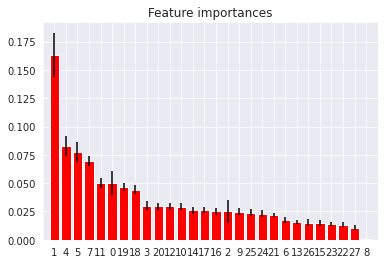

In [8]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print('Feature ranking:')
df = pd.DataFrame()
for i, j in zip(x_train_tree, forest.feature_importances_):
    aux = pd.DataFrame({'feature': i, 'importances': j}, index=[0])
    df = pd.concat([df, aux], axis=0)

print(df.sort_values('importances', ascending=False))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train_tree.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train_tree.shape[1]), indices)
plt.xlim([-1, x_train_tree.shape[1]])
plt.show()

# ML Model

## Data Input

In [48]:
x_train = pd.read_csv('../data/processed/x_balanced.csv')
x_test  = pd.read_csv('../data/processed/X_test.csv').drop(columns='id')

y_train = pd.read_csv('../data/processed/y_balanced.csv')
y_test = pd.read_csv('../data/processed/y_test.csv')

## Baseline Model

Accuracy: 40.0%
Balanced Accuracy Score: 10.0%
Kappa Score: 0.0015926215507006125


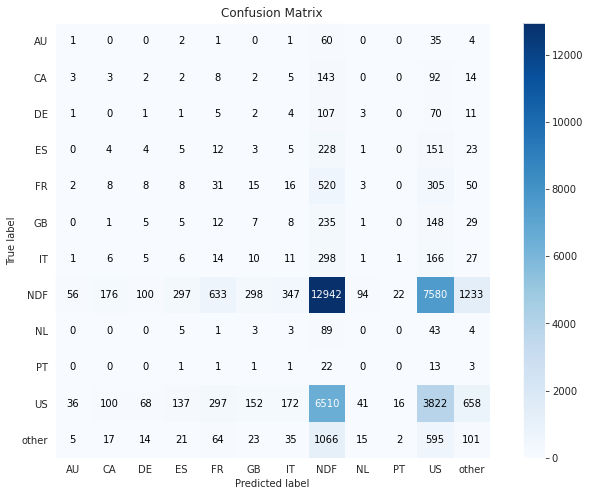

In [49]:
# Model definition
baseline_model = DummyClassifier(strategy='stratified', random_state=seed)

# Train
baseline_model.fit(x_train, y_train)

# prediction
yhat = baseline_model.predict(x_test)

# performance
model_evaluation(y_test, yhat)

### Cross-Validation

In [50]:
np.mean(cross_val_score(DummyClassifier(strategy='stratified', random_state=seed), x_train, y_train,
               scoring='accuracy'))

0.3995986487842403

## Neural Network

In [51]:
# Model definition
model = models.Sequential()
model.add(layers.Dense(64, input_dim=x_train.shape[1], activation='relu'))
model.add(layers.Dense(12, activation='softmax'))

# model compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# encode
ohe = OneHotEncoder()
y_train_nn = ohe.fit_transform(y_train).toarray()

# Train
model.fit(x_train, y_train_nn, epochs=30)

Epoch 1/30
4672/4672 [==============================] - 3s 618us/step - loss: 1.2747 - accuracy: 0.5302
Epoch 2/30
4672/4672 [==============================] - 3s 619us/step - loss: 1.2433 - accuracy: 0.5403
Epoch 3/30
4672/4672 [==============================] - 3s 617us/step - loss: 1.2343 - accuracy: 0.5413
Epoch 4/30
4672/4672 [==============================] - 3s 622us/step - loss: 1.2302 - accuracy: 0.5414
Epoch 5/30
4672/4672 [==============================] - 3s 622us/step - loss: 1.2282 - accuracy: 0.5414
Epoch 6/30
4672/4672 [==============================] - 3s 623us/step - loss: 1.2271 - accuracy: 0.5413
Epoch 7/30
4672/4672 [==============================] - 3s 623us/step - loss: 1.2260 - accuracy: 0.5413
Epoch 8/30
4672/4672 [==============================] - 3s 628us/step - loss: 1.2254 - accuracy: 0.5413
Epoch 9/30
4672/4672 [==============================] - 3s 624us/step - loss: 1.2247 - accuracy: 0.5413
Epoch 10/30
4672/4672 [==============================] - 3s 622u

In [52]:
# Prediction
pred_nn = model.predict(x_test)

# Invert prediction
yhat_nn = ohe.inverse_transform(pred_nn).flatten()

# Prediction prepare
y_test_nn = y_test.copy()

Accuracy: 60.0%
Balanced Accuracy Score: 10.0%
Kappa Score: 0.00043834143981680285


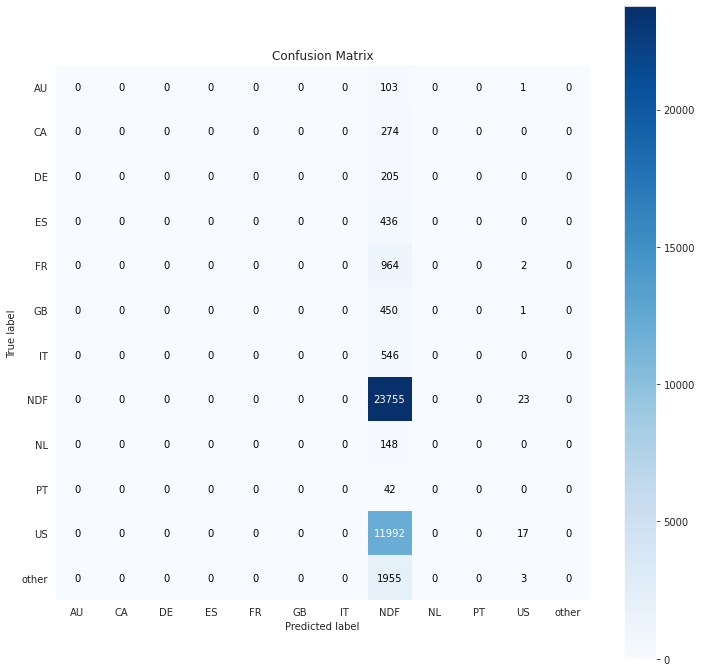

In [53]:
# Accuracy
print(f'Accuracy: {round(accuracy_score(y_test_nn, yhat_nn), 1) * 100}%')
print(f'Balanced Accuracy Score: {round(balanced_accuracy_score(y_test_nn, yhat_nn), 1) * 100}%')
print(f'Kappa Score: {cohen_kappa_score(y_test_nn, yhat_nn)}')

# Confusion Matrix
plot_confusion_matrix(y_test_nn, yhat_nn, figsize=(12, 12))
plt.show()

### Neural Network Cross-Validation

In [93]:
n_folds = 5
kfold = StratifiedKFold(n_folds, shuffle=True, random_state=seed)

y_train_f = pd.Series(ohe.inverse_transform(y_train).ravel())
accuracy_list = list()
balanced_accuracy_list = list()
kappa_score_list = list()

for train_ix, val_ix in kfold.split(x_train, y_train_f):
    # Data
    x_train_fold = x_train.iloc[train_ix]
    y_train_fold = y_train_f.iloc[train_ix]
    
    x_val_fold = x_train.iloc[val_ix]
    y_val_fold = y_train_f.iloc[val_ix]
    
    # Model definition
    model = models.Sequential()
    model.add(layers.Dense(128, input_dim=x_train_fold.shape[1], activation='relu'))
    model.add(layers.Dense(12, activation='softmax'))
    
    # model compile
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # OneHotEncoder
    y_train_fold = ohe.fit_transform(y_train_fold.values.reshape(-1, 1)).toarray()
    # Train
    model.fit(x_train_fold, y_train_fold, epochs=100, verbose=0)
    
    # Prediction
    pred_nn = model.predict(x_val_fold)
    
    # Invert prediction
    yhat_nn = ohe.inverse_transform(pred_nn).flatten()
    
    # Prediction prepare
    y_test_nn = y_val_fold.to_numpy().flatten()
    
    #Evaluation
    ac, bc, ks = model_evaluation_cv(y_test_nn, yhat_nn)
    accuracy_list.append(ac)
    balanced_accuracy_list.append(bc)
    kappa_score_list.append(ks)
    
print(f'Accuracy Score: {round(np.mean(accuracy_list), 2)} ± {round(np.std(accuracy_list), 2)}')
print(f'Balanced Accuracy Score: {round(np.mean(balanced_accuracy_list), 2)} ± {round(np.std(balanced_accuracy_list), 2)}')
print(f'Kappa Score: {round(np.mean(kappa_score_list), 4)} ± {round(np.std(kappa_score_list), 4)}')

2021-12-21 16:58:12.258953: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 158662800 exceeds 10% of free system memory.
2021-12-21 17:02:49.683279: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 158662800 exceeds 10% of free system memory.
2021-12-21 17:07:28.652975: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 158662800 exceeds 10% of free system memory.
2021-12-21 17:11:55.028490: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 158662800 exceeds 10% of free system memory.


Accuracy Score: 0.87 ± 0.0
Balanced Accuracy Score: 0.17 ± 0.0
Kappa Score: 0.766 ± 0.0003


## Data Output

# Model Performance

# Deploy